In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
import matplotlib.pyplot as plt


#### Classification

In [2]:
# Generate synthetic data
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_x, calib_x, train_y, calib_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [3]:
# Train a scikit-learn model
model = HistGradientBoostingClassifier(random_state=42)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.938

In [4]:
# 1: Get conformal scores
n = calib_y.shape[0]
cal_smx = model.predict_proba(calib_x) # shape (n, n_classes)
# scores from the softmax score for the correct class
cal_scores = 1 - cal_smx[np.arange(n), calib_y] # shape (n,)

In [5]:
# 2: Get adjusted quantile
alpha = 0.1  # Confidence level (1 - alpha)
q_level = np.ceil((n + 1) * (1 - alpha)) / n
qhat = np.quantile(cal_scores, q_level, method='higher')

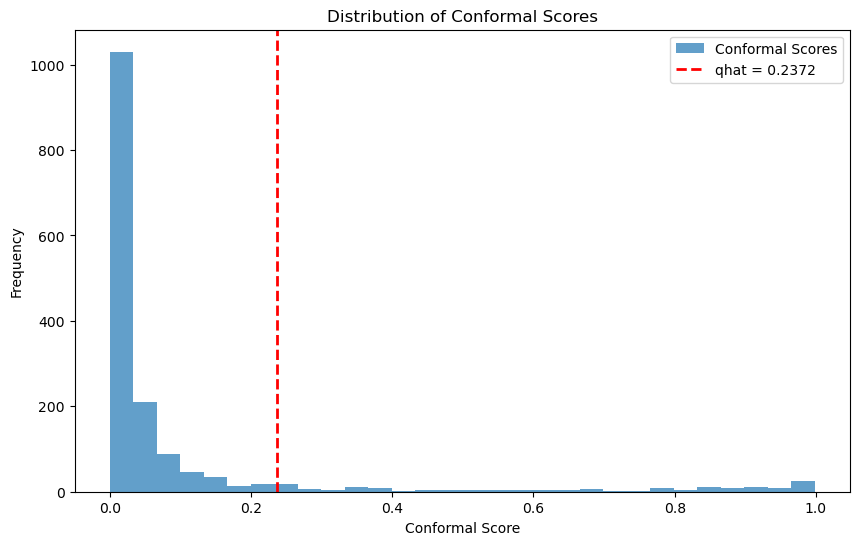

In [6]:
# Visualize the distribution of conformal scores
plt.figure(figsize=(10, 6))
plt.hist(cal_scores, bins=30, alpha=0.7, label='Conformal Scores')
plt.axvline(qhat, color='red', linestyle='dashed', linewidth=2, label=f'qhat = {qhat:.4f}')
plt.title('Distribution of Conformal Scores')
plt.xlabel('Conformal Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# 3: Form prediction sets
val_smx = model.predict_proba(test_x)
prediction_sets = val_smx >= (1 - qhat)

In [8]:
# Evaluate coverage
coverage_by_class = [np.mean([test_y[i] in np.where(prediction_sets[i])[0] for i in range(len(test_y)) if test_y[i] == c]) for c in np.unique(test_y)]
print(dict(zip(np.unique(test_y), coverage_by_class)))

{0: 0.8936381709741551, 1: 0.9175050301810865}


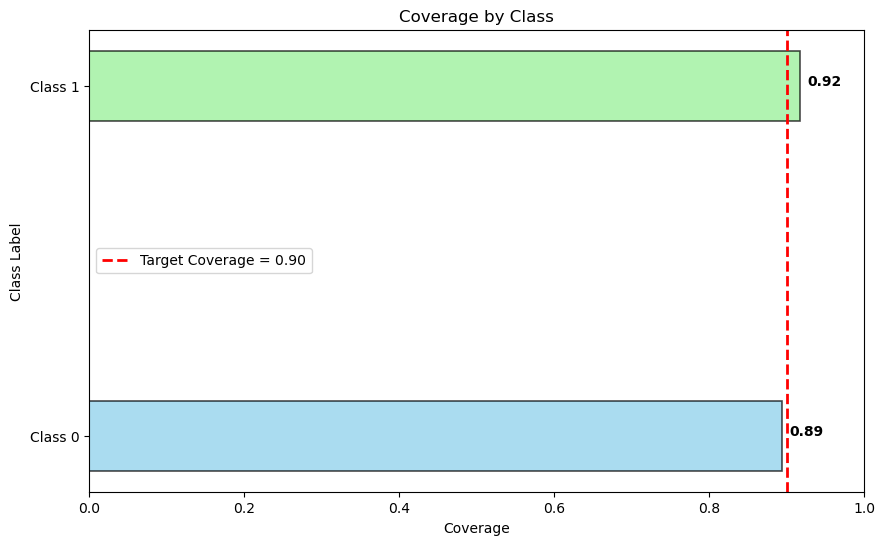

In [9]:
# Visualize the coverage of the prediction sets
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'lightgreen']
class_labels = ['Class 0', 'Class 1']  # Add class labels
plt.barh(class_labels, coverage_by_class, alpha=0.7, color=colors, height=0.2, edgecolor='black', linewidth=1.2)
plt.axvline(1 - alpha, color='red', linestyle='dashed', linewidth=2, label=f'Target Coverage = {1 - alpha:.2f}')
plt.title('Coverage by Class')
plt.xlabel('Coverage')
plt.ylabel('Class Label')
plt.xlim(0, 1)

# Annotate coverage values
for i, v in enumerate(coverage_by_class):
    plt.text(v + 0.01, i, f'{v:.2f}', color='black', fontweight='bold')

plt.legend()
plt.show()


#### Regression

In [10]:
# Generate synthetic regression data
X, y = make_regression(n_samples=10000, n_features=20, noise=0.1, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_x, calib_x, train_y, calib_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [11]:
# Train a scikit-learn regression model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.974117712472956

In [12]:
# 1: Get conformal scores
calib_preds = model.predict(calib_x)
cal_scores = np.abs(calib_y - calib_preds)

In [13]:
# 2: Get adjusted quantile
alpha = 0.1  # Confidence level (1 - alpha)
n_cal = len(cal_scores)
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(cal_scores, q_level, method='higher')

In [14]:
# 3: Form prediction intervals
test_preds = model.predict(test_x)
lower_bounds = test_preds - qhat
upper_bounds = test_preds + qhat

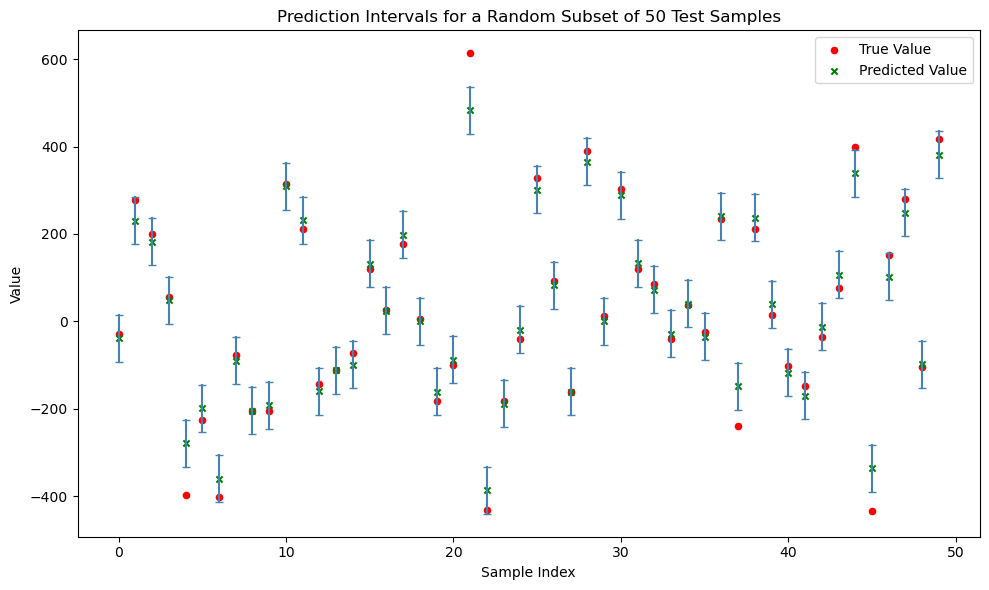

In [15]:
# Visualize the prediction intervals for a subset of the test data
subset_size = 50
subset_indices = np.random.choice(len(test_y), size=subset_size, replace=False)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(subset_indices):
    plt.plot([i, i], [lower_bounds[idx], upper_bounds[idx]], color='steelblue', marker='_', linewidth=1.5)
    plt.scatter(i, test_y[idx], color='red', marker='o', s=20, label='True Value' if i == 0 else "")
    plt.scatter(i, test_preds[idx], color='green', marker='x', s=20, label='Predicted Value' if i == 0 else "")

plt.title(f'Prediction Intervals for a Random Subset of {subset_size} Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate coverage
coverage = np.mean((test_y >= lower_bounds) & (test_y <= upper_bounds))
print(f"Coverage: {coverage * 100:.2f}%")

Coverage: 91.70%


<Axes: title={'center': 'Distribution of Width of Interval'}, ylabel='Frequency'>

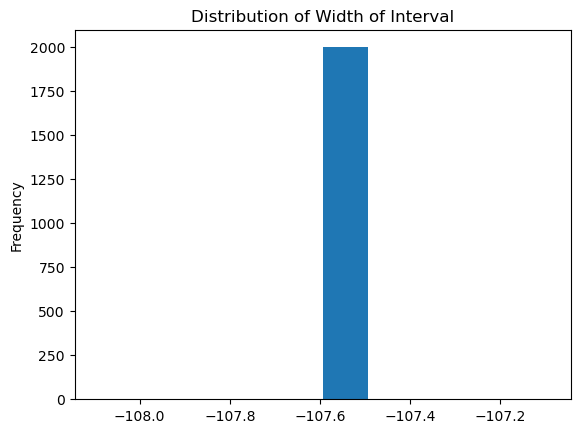

In [25]:
# Plotting the distribution of the width of prediction interval.
# This should be the same because we are using same qhat for all intervals.
pd.Series(lower_bounds-upper_bounds).round(4).plot(kind="hist", title="Distribution of Width of Interval")

### Conformalised Quantile Regression (Score Function) 

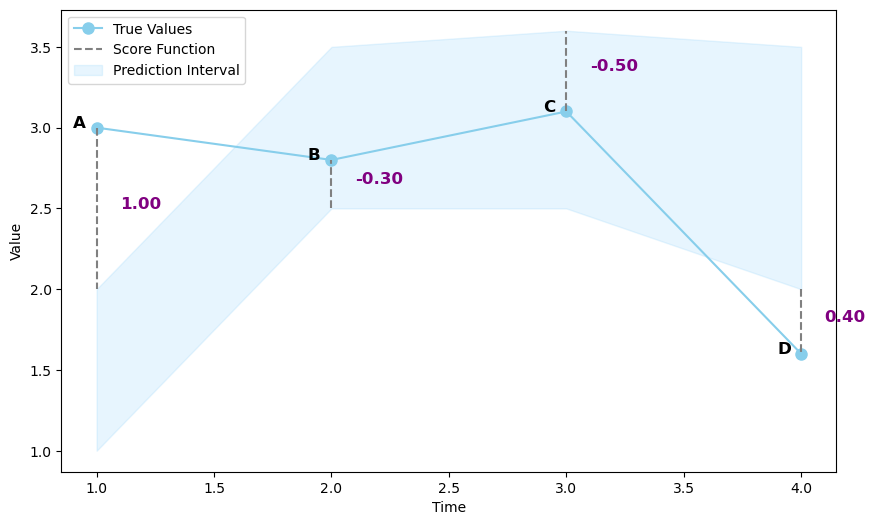

In [14]:
# Hypothetical time series data for three points with varied true values
time_points = np.array([1, 2, 3, 4])
y_true = np.array([3.0, 2.8, 3.1, 1.6])  # Adjusting true values
y_pred_alpha = np.array([1.0, 2.5, 2.5, 2.0])
y_pred_1_alpha = np.array([2.0, 3.5, 3.6, 3.5])

# Calculate the scores
scores = np.maximum(y_true - y_pred_alpha , y_pred_1_alpha - y_true)

# Plot the time series data with prediction intervals
plt.figure(figsize=(10, 6))
plt.plot(time_points, y_true, color='skyblue', label='True Values', marker='o', linestyle='-', markersize=8)
# plt.plot(time_points, y_pred_alpha, color='red', linestyle='--', label=f'{alpha}-th Quantile Prediction', marker='x')
# plt.plot(time_points, y_pred_1_alpha, color='green', linestyle='--', label=f'{1-alpha}-th Quantile Prediction', marker='x')

# Add drop lines to show the scores and highlight the max deviation
for i, alphabet in zip(range(len(time_points)), ["A", "B", "C", "D"]):
    lower_deviation = y_pred_alpha[i]-y_true[i]
    upper_deviation = y_true[i] - y_pred_1_alpha[i]
    max_deviation = max(lower_deviation, upper_deviation) #scores[i]
    
    if max_deviation == lower_deviation:
        plt.vlines(time_points[i], y_pred_alpha[i], y_true[i], color='gray', linestyle='--', label='' if i else 'Score Function')
        plt.text(time_points[i] + 0.1, (y_pred_alpha[i] + y_true[i]) / 2, f'{max_deviation:.2f}', color='purple', fontsize=12, fontweight='bold')
    else:
        plt.vlines(time_points[i], y_true[i], y_pred_1_alpha[i], color='gray', linestyle='--', label='' if i else 'Score Function')
        plt.text(time_points[i] + 0.1, (y_pred_1_alpha[i] + y_true[i]) / 2, f'{max_deviation:.2f}', color='purple', fontsize=12, fontweight='bold')
    plt.text(time_points[i] - 0.1, y_true[i], alphabet, color='black', fontsize=12, fontweight='bold')

plt.fill_between(time_points, y_pred_alpha, y_pred_1_alpha, color='lightskyblue', alpha=0.2, label='Prediction Interval')
# plt.title('Visualization of Conformalized Quantile Regression Score Function with Varied True Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()
